In [1]:
from pathlib import Path
import os, sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Make sure we're running from the repo root, not notebooks/
repo_root = Path.cwd().parent.parent
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from common.config_manager import ConfigManager
from common.io import read_csv

# Breakout Artists - EDA

## Context
We start from scrobble-level data (1 row per scrobble).  
The goal of this notebook is to:
1) Validate the dataset is clean enough to use
2) Extract initial insights relevant to the breakout problem
3) Decide what aggregations and features are worth building


In [3]:
cfg = ConfigManager(repo_root)
project_cfg = cfg.project()
sources_cfg = cfg.sources()
breakout_cfg = cfg.breakout()

scrobbles_path = repo_root / sources_cfg["scrobbles"]["path"]
required_cols = sources_cfg["scrobbles"]["required_columns"]

df_raw = read_csv(scrobbles_path)
print("Raw shape:", df_raw.shape)
df_raw.head(10)


D:\Transferências\Desktop\01. Projects\09. ML Zoomcamp\artist-lifecycle\common\io.py:49: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, usecols=usecols, dtype=dtype, parse_dates=parse_dates)


Raw shape: (160830, 37)


,scrobble_number,username,track_name,track_mbid,date,artist_name,artist_mbid,album_name,album_mbid,artist_listeners,...,added_at_utc_was_missing,week_saturday_utc_was_missing,spotify_release_date_was_missing,genre_bucket,genre_missing,artist_listeners_was_missing,artist_playcount_was_missing,album_listeners_was_missing,album_playcount_was_missing,spotify_popularity_was_missing
0,1,Tyains,Lover Boy - A COLORS SHOW,NaN,2020-04-01 17:47:00,Phum Viphurit,8dc1023a-8c0a-4b59-8727-dd5bd22e0524,Lover Boy - A COLORS SHOW,NaN,238293,...,1,0,0,pop,0,0,0,0,0,0
1,2,Tyains,Pluto - Audiotree Live Version,NaN,2020-04-01 17:43:00,Phum Viphurit,NaN,Phum Viphurit on Audiotree Live,NaN,238293,...,1,0,0,pop,0,0,0,0,0,0
2,3,Tyains,"Hello, Anxiety - Audiotree Live Version",NaN,2020-04-01 17:39:00,Phum Viphurit,NaN,Phum Viphurit on Audiotree Live,NaN,238293,...,1,0,0,pop,0,0,0,0,0,0
3,4,Tyains,Sanctuary,02c2b134-62a8-4e72-8236-fb9b7faed23b,2020-04-01 17:35:00,Joji,8264722b-df00-467a-858e-5c97cda169c9,Sanctuary,20dd31b3-8174-4aff-8e73-5140d2a06c08,2033690,...,1,0,0,unknown,1,0,0,0,0,0
4,5,Tyains,Excuse Me,53e393f4-5e41-4a4d-86c0-01952c69cbd8,2020-04-01 17:30:00,Salvador Sobral,ad226273-7870-47d6-a8d0-903ddba3853d,Excuse Me,f63f9325-b5d7-4e5c-8184-fd9d0682978f,67237,...,1,0,0,world_regional,0,0,0,0,0,0
5,6,Tyains,Mano a Mano,NaN,2020-04-01 17:26:00,Salvador Sobral,ad226273-7870-47d6-a8d0-903ddba3853d,Mano a Mano,NaN,67237,...,1,0,0,world_regional,0,0,0,0,0,0
6,7,Tyains,Anda Estragar-me Os Planos,1e4a1d11-08fc-4f02-b557-08f87768c725,2020-04-01 17:23:00,Salvador Sobral,ad226273-7870-47d6-a8d0-903ddba3853d,"Paris, Lisboa",a0898280-0763-4dd9-bf60-af91d34071ca,67237,...,1,0,0,world_regional,0,0,0,0,0,0
7,8,Tyains,Só Um Beijo,NaN,2020-04-01 17:20:00,Luisa Sobral,NaN,Rosa,NaN,13960,...,1,0,0,world_regional,0,0,0,0,0,0
8,9,Tyains,Amar pelos dois,4810c5b5-4a04-40d2-bb0b-8769445ecc72,2020-04-01 17:17:00,Salvador Sobral,ad226273-7870-47d6-a8d0-903ddba3853d,Amar pelos dois,0874be69-2918-4ff4-ab19-6a632ed17675,67237,...,1,0,0,world_regional,0,0,0,0,0,0
9,10,Tyains,Antes dela dizer que sim,ec4cccd2-93ae-40a9-8d4f-39a3edafed62,2020-04-01 17:13:00,Bárbara Tinoco,4268daf5-68f2-4c6e-a8c7-3e1d17fbf011,Antes Dela Dizer Que Sim,051b150b-e576-4836-932b-39e966b21208,15531,...,1,0,0,hip_hop_rap,0,0,0,0,0,0


## Profiling - quick overview

In [7]:
print("Columns:", list(df_raw.columns))
print(f"Rows: {len(df_raw):,} | Columns: {len(df_raw.columns)}")

print(pd.DataFrame({"column": df_raw.columns, "dtype": df_raw.dtypes.values}))

print("Unique artists:", df_raw["artist_name"].nunique() if "artist_name" in df_raw.columns else None)
print("Unique tracks:", df_raw["track_name"].nunique() if "track_name" in df_raw.columns else None)

df_raw[required_cols].head(5)

Columns: ['scrobble_number', 'username', 'track_name', 'track_mbid', 'date', 'artist_name', 'artist_mbid', 'album_name', 'album_mbid', 'artist_listeners', 'artist_playcount', 'artist_key', 'track_duration', 'track_key', 'album_listeners', 'album_playcount', 'album_key', 'spotify_track_id', 'spotify_album', 'spotify_release_date', 'spotify_popularity', 'spotify_genres', 'week_saturday_utc', 'added_at_utc', 'is_week_favorite', 'release_date_granularity', 'date_was_missing', 'added_at_utc_was_missing', 'week_saturday_utc_was_missing', 'spotify_release_date_was_missing', 'genre_bucket', 'genre_missing', 'artist_listeners_was_missing', 'artist_playcount_was_missing', 'album_listeners_was_missing', 'album_playcount_was_missing', 'spotify_popularity_was_missing']
Rows: 160,830 | Columns: 37
                              column    dtype
0                    scrobble_number    int64
1                           username   object
2                         track_name   object
3                    

,artist_name,track_name,date
0,Phum Viphurit,Lover Boy - A COLORS SHOW,2020-04-01 17:47:00
1,Phum Viphurit,Pluto - Audiotree Live Version,2020-04-01 17:43:00
2,Phum Viphurit,"Hello, Anxiety - Audiotree Live Version",2020-04-01 17:39:00
3,Joji,Sanctuary,2020-04-01 17:35:00
4,Salvador Sobral,Excuse Me,2020-04-01 17:30:00


In [10]:
# A compact summary
profile_table = df_raw.describe(include='all').T
profile_table

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
scrobble_number,160830.0,NaN,NaN,NaN,80415.5,46427.766234,1.0,40208.25,80415.5,120622.75,160830.0
username,160830,1,Tyains,160830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_name,160830,25420,Intro,284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_mbid,117971,17902,ddea782b-e8df-4291-823a-d72a5e7b15e1,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,160830,158723,2025-09-08 21:19:00,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_name,160830,2920,King Gizzard & The Lizard Wizard,5444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_mbid,129158,2045,f58384a4-2ad2-4f24-89c5-c7b74ae1cce7,5233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
album_name,160829,6323,Ants From Up There,781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
album_mbid,121976,3250,0788e1b9-d989-4a8f-9a9a-244d6338f014,781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_listeners,160830.0,NaN,NaN,NaN,1532794.778729,3884957.928297,2.0,305793.0,767778.0,2051759.0,124096307.0


## Missing values

In [8]:
missing = (
    df_raw.isna()
    .sum()
    .rename("missing")
    .to_frame()
)
missing["pct"] = (missing["missing"] / len(df_raw)).round(4)
missing = missing.sort_values(["pct", "missing"], ascending=False)

missing.head(30)


,missing,pct
added_at_utc,158752,0.9871
spotify_genres,46585,0.2897
track_mbid,42859,0.2665
album_mbid,38854,0.2416
artist_mbid,31672,0.1969
spotify_album,8176,0.0508
spotify_track_id,8175,0.0508
spotify_release_date,8175,0.0508
release_date_granularity,8175,0.0508
album_name,1,0.0000


## String cleanliness (artist_name / track_name)

In [11]:
artist_empty = df_raw["artist_name"].astype("string").str.strip().eq("").sum()
track_empty = df_raw["track_name"].astype("string").str.strip().eq("").sum()

print("Empty artist_name after strip:", artist_empty)
print("Empty track_name after strip:", track_empty)

# quick peek at suspicious rows
df_raw.loc[
    df_raw["artist_name"].astype("string").str.strip().eq("") |
    df_raw["track_name"].astype("string").str.strip().eq(""),
    ["artist_name", "track_name", "date"]
].head(10)


Empty artist_name after strip: 0
Empty track_name after strip: 0


,artist_name,track_name,date


## Date column - parse checks, range, invalid values

In [13]:
played = pd.to_datetime(df_raw["date"], utc=True, errors="coerce")

invalid = played.isna().sum()
print("Invalid date values:", invalid)
print("Invalid date %:", round(invalid / len(df_raw), 6))

if invalid > 0:
    bad_examples = df_raw.loc[played.isna(), "date"].head(10).tolist()
    print("Bad examples:", bad_examples)

print("Min played_at_utc:", played.min())
print("Max played_at_utc:", played.max())

# future check (defensive)
now_utc = pd.Timestamp.now().tz_localize("UTC")
future_rows = (played > now_utc).sum()
print("Future timestamps:", future_rows)


Invalid date values: 0
Invalid date %: 0.0
Min played_at_utc: 2020-03-17 01:02:00+00:00
Max played_at_utc: 2025-11-11 17:31:00+00:00
Future timestamps: 0


## Duplicates

In [21]:
dup_exact = int(df_raw.duplicated().sum())

dup_scrobble = None
if "scrobble_number" in df_raw.columns:
    dup_scrobble = int(df_raw.duplicated(subset=["scrobble_number"]).sum())

pd.DataFrame(
    [
        {"check": "exact_row", "dupe_count": dup_exact},
        {"check": "scrobble_number", "dupe_count": dup_scrobble},
    ]
)

,check,dupe_count
0,exact_row,0
1,scrobble_number,0


## Basic time activity overview
We want to understand volume, coverage, and whether the dataset spans enough history for artist-month modeling.

In [28]:
played_ok = played.dropna()
month = played_ok.dt.strftime("%Y-%m-01")
month = pd.to_datetime(month, utc=True)

scrobbles_per_month = (
    pd.Series(1, index=month)
    .groupby(level=0)
    .sum()
    .sort_index()
)

print("Months:", scrobbles_per_month.index.min(), "->", scrobbles_per_month.index.max())
print('Min Monhtly Scrobbles:', scrobbles_per_month.min() )
print('Max Monhtly Scrobbles:', scrobbles_per_month.max() )


Months: 2020-03-01 00:00:00+00:00 -> 2025-11-01 00:00:00+00:00
Min Monhtly Scrobbles: 764
Max Monhtly Scrobbles: 5027


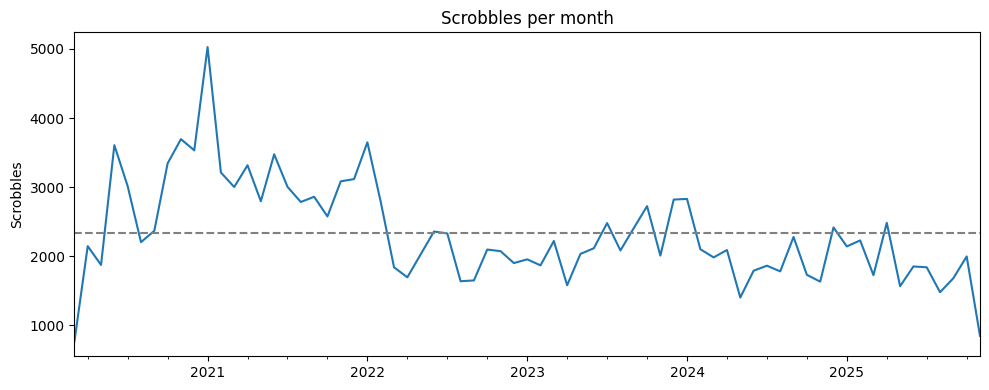

In [22]:
y_mean = scrobbles_per_month.mean()

plt.figure(figsize=(10, 4))
scrobbles_per_month.plot(kind="line")
plt.axhline(y_mean, linestyle="--", color="grey")
plt.title("Scrobbles per month")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.tight_layout()
plt.show()


              genre_bucket  scrobbles
0                  unknown      46585
1              hip_hop_rap      38217
2                     rock      14494
3                      pop      14108
4                    other      12553
5   folk_country_americana       6826
6                 rnb_soul       6758
7            classical_art       5627
8           world_regional       4145
9                    latin       3497
10        electronic_dance       2577
11                    jazz       2562
12      experimental_avant       1955
13              metal_hard        926


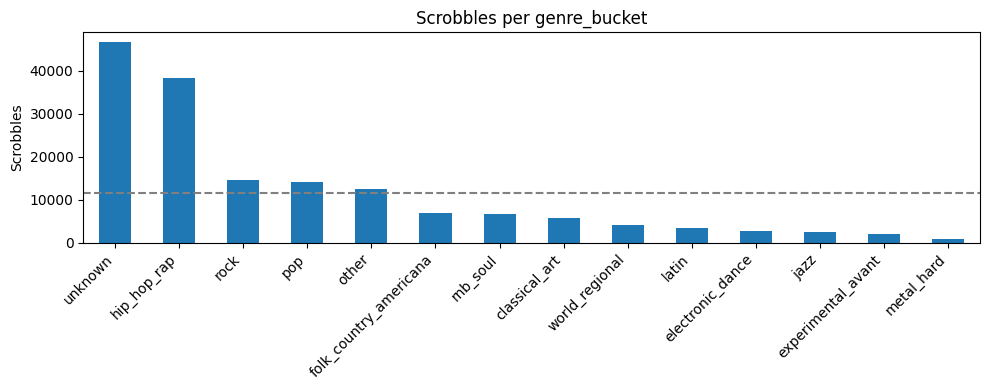

In [29]:

genre_counts = (
    df_raw["genre_bucket"]
    .fillna("Unknown")
    .astype("string")
    .str.strip()
    .replace({"": "Unknown"})
    .value_counts()
)

print(genre_counts.head(20).rename_axis("genre_bucket").reset_index(name="scrobbles"))

y_mean = genre_counts.mean()

plt.figure(figsize=(10, 4))
genre_counts.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color="grey")
plt.title("Scrobbles per genre_bucket")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Visual EDA
This section focuses on plots and high-level distribution insights.


## Initial distribution checks (artists / tracks)

                             artist  scrobbles
0  King Gizzard & The Lizard Wizard       5444
1                        Kanye West       4658
2                    Sufjan Stevens       4408
3                         JPEGMAFIA       3650
4                     Freddie Gibbs       2326
5                       Ichiko Aoba       2283
6                    Kendrick Lamar       2035
7                       David Bruno       2026
8                       Beach House       1952
9                       Fleet Foxes       1950

Mean top 100 artists: 917.37


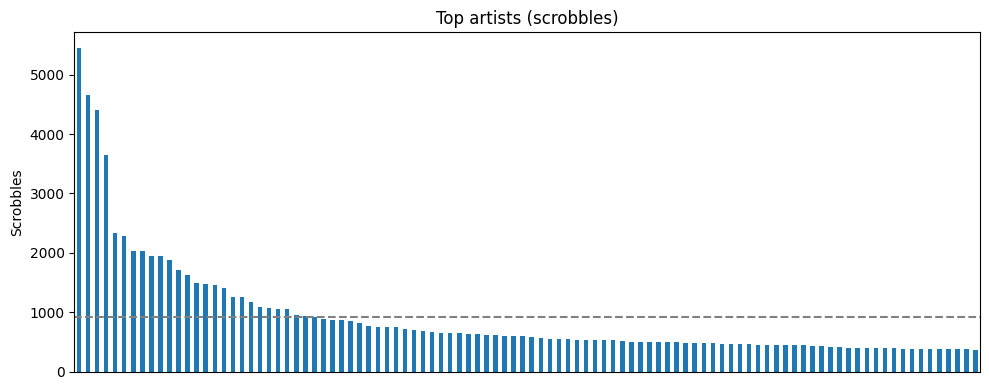

                              track_name              artist_name  scrobbles
0                               Concorde  Black Country, New Road        125
1                           Weird Fishes          Lianne La Havas        117
2                       Basketball Shoes  Black Country, New Road        115
3                     Chaos Space Marine  Black Country, New Road        112
4                          Feel the Love          KIDS SEE GHOSTS        104
5                       HAZARD DUTY PAY!                JPEGMAFIA        103
6                     Helplessness Blues              Fleet Foxes        100
7                             Sunglasses  Black Country, New Road         99
8  The Place Where He Inserted The Blade  Black Country, New Road         99
9                                Runaway               Kanye West         97

Mean top 100 tracks: 76.32


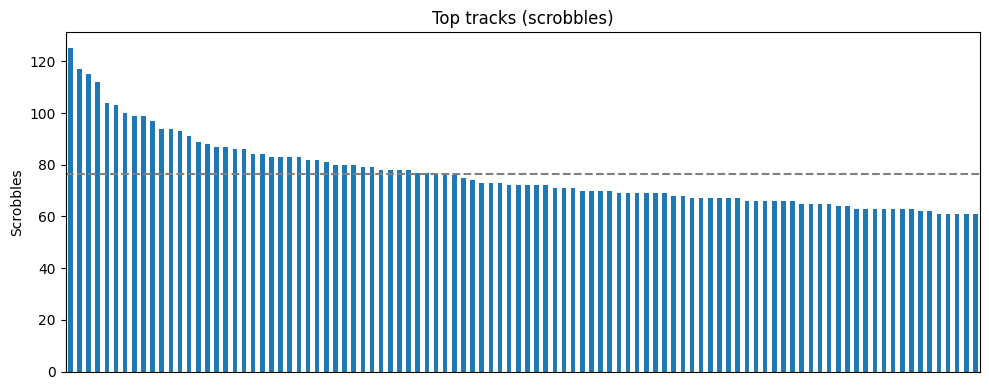

In [26]:
top_n = 100

top_artists = df_raw["artist_name"].astype("string").str.strip().value_counts().head(top_n)
y_mean = top_artists.mean()

print(top_artists.head(10).rename_axis("artist").reset_index(name="scrobbles"))
print(f"\nMean top {top_n} artists: {y_mean}")

plt.figure(figsize=(10, 4))
top_artists.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color="grey")
plt.title("Top artists (scrobbles)")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.xticks([], [])
plt.tight_layout()
plt.show()


top_tracks = df_raw[["track_name", "artist_name"]].astype("string").apply(lambda s: s.str.strip()).value_counts().head(top_n)
y_mean = top_tracks.mean()

print(top_tracks.head(10).reset_index(name="scrobbles"))
print(f"\nMean top {top_n} tracks: {y_mean}")

plt.figure(figsize=(10, 4))
top_tracks.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color="grey")
plt.title("Top tracks (scrobbles)")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.xticks([], [])
plt.tight_layout()
plt.show()
